# Modelo RNC para abstracción de características

## Blanco y Negro

Forma de los tensores de entrada: (15, 224, 224, 1)


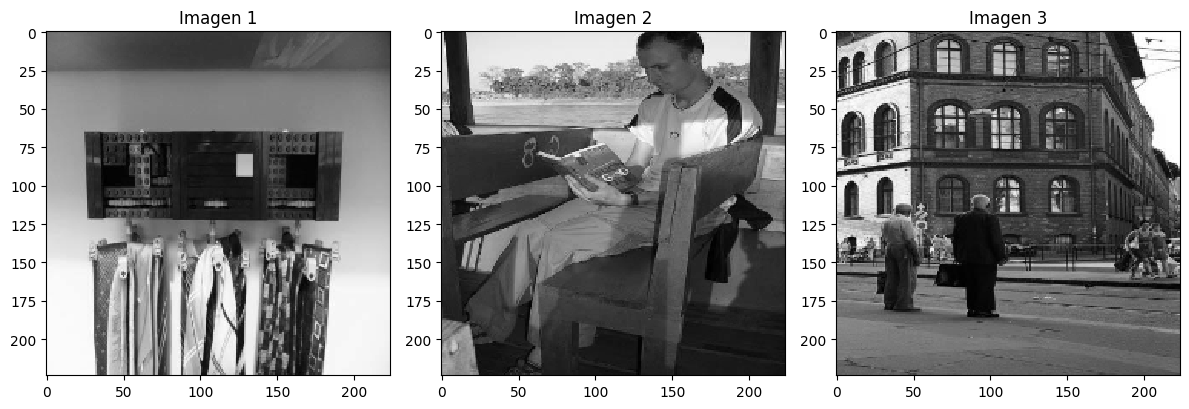

In [ ]:
##Funcion que cambia el tamaño de la imagen,se asegura que que este normalizada
def cargar_y_preprocesar_BW(path, tamano=(224, 224)):
    # Cargar imagen en escala de grises
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"No se pudo cargar: {path}")

    # Normalizar según el tipo de bits
    if img.dtype == np.uint16:
        img = img.astype(np.float32) / 65535.0
    else:
        img = img.astype(np.float32) / 255.0

    # Redimensionar
    img = cv2.resize(img, tamano)

    # Agregar dimensión de canal (Keras espera 4D: batch, alto, ancho, canales)
    img = img.reshape(tamano[0], tamano[1], 1)

    return img

#Cargar las imágenes desde carpeta
ruta_imagenes = "/content/ImagesBW"
paths = sorted(glob(os.path.join(ruta_imagenes, "*.jpg")))
imgs = np.array([cargar_y_preprocesar_BW(p) for p in paths], dtype=np.float32)

print("Forma de los tensores de entrada:", imgs.shape)

# Mostrar las imágenes cargadas
plt.figure(figsize=(12, 4))
for i in range(min(3, len(imgs))):
    plt.subplot(1, 3, i + 1)
    plt.imshow(imgs[i].squeeze(), cmap="gray", interpolation="nearest")
    plt.title(f"Imagen {i+1}")
plt.tight_layout()
plt.show()

In [ ]:
##Definir entrada del modelo con la misma forma que las imágenes cargadas
inputs = keras.Input(shape=imgs.shape[1:])
#Capa convolucional 2D con 2 filtros de tamaño 7x7, paso de pixeles de 1, tamaño de salida igual al de entrada y funcion de activacion relu
x = keras.layers.Conv2D(filters=5, kernel_size=3, strides=1, padding="SAME", activation="relu")(inputs)
#Capa de max pooling que reduce a la mitad el tamaño espacial (altura y ancho)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
#Promedio global de cada mapa de características
x = keras.layers.GlobalAvgPool2D()(x)
x = keras.layers.Flatten()(x)
#Capa de salida con 2 neuronas (correspondientes a 2 clases).
outputs = keras.layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 5)    │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 112, 112, 5)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 5)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62 (248.00 B)

 Trainable params: 62 (248.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Como no tenemos etiquetas reales, se generarán aleatoriamente para ejemplo
etiquetas = np.random.randint(0, 2, size=(len(imgs),))

# Compilar y entrenar modelo
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(imgs, etiquetas, epochs=5)

# Visualizar salidas de los feature maps
salidas = keras.Model(inputs=model.input, outputs=model.layers[1].output)  # capa de conv2D
activaciones = salidas.predict(imgs)

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7333 - loss: 0.6907
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.7333 - loss: 0.6901
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.7333 - loss: 0.6894
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.7333 - loss: 0.6888
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.7333 - loss: 0.6882


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


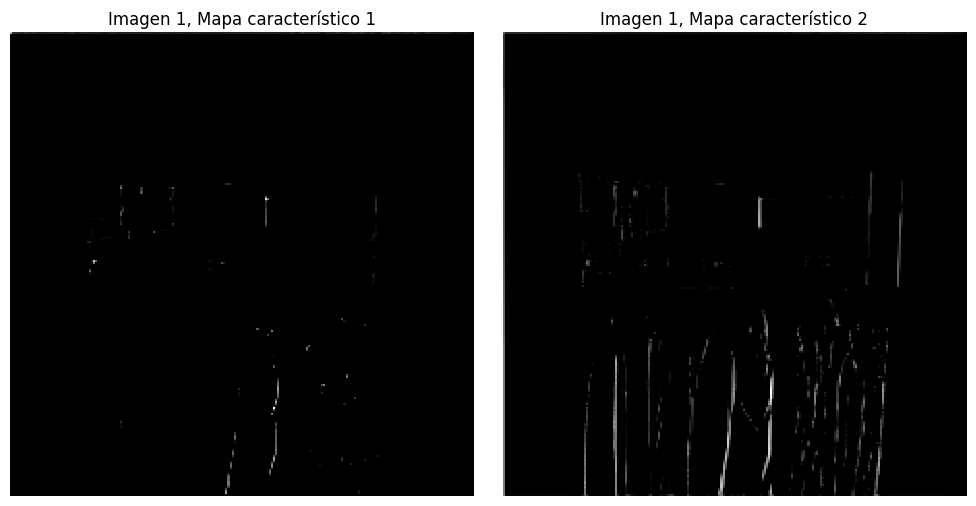

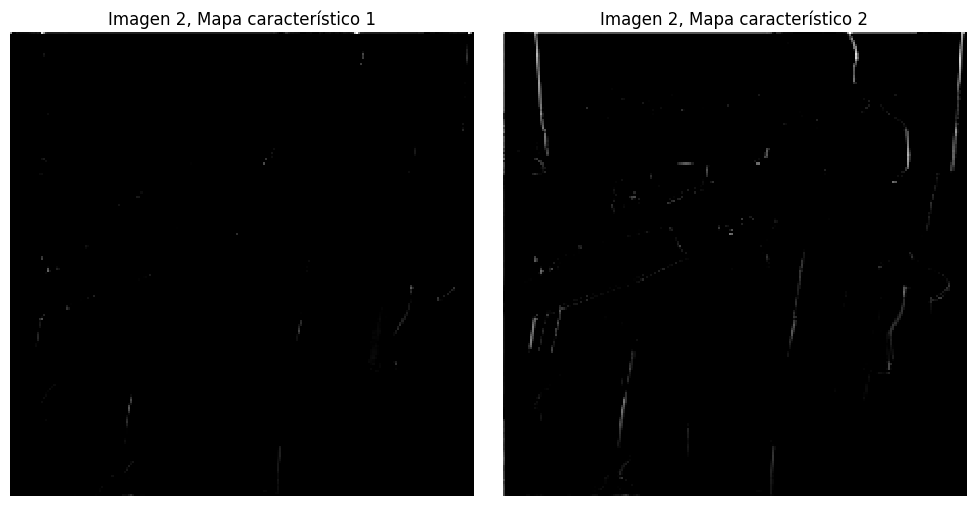

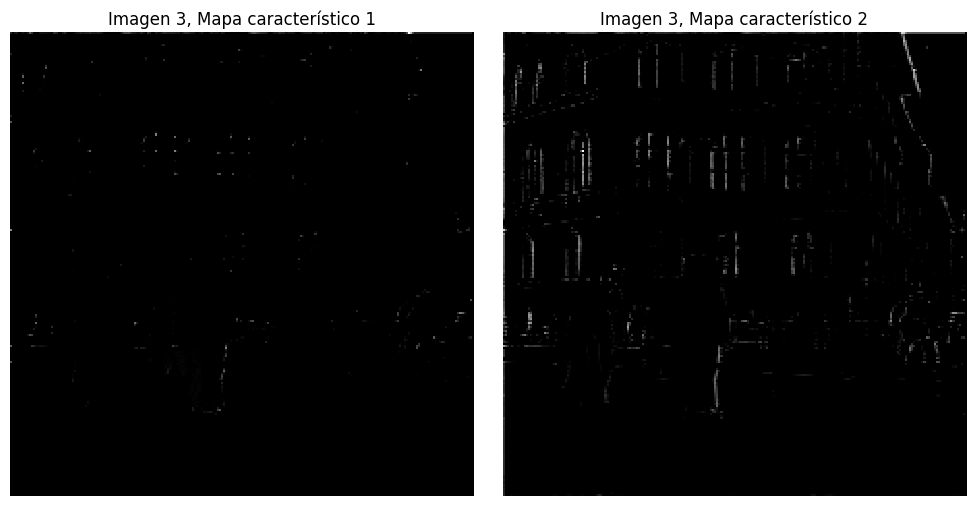

In [ ]:
# Graficar los mapas de características de las imagenes
for img_idx in range(min(3, len(imgs))):
    plt.figure(figsize=(10, 5))
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plot_image(activaciones[img_idx, :, :, i])
        plt.title(f"Imagen {img_idx+1}, Mapa característico {i+1}")
    plt.tight_layout()
    plt.show()

## Color 16 bits

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob
from functools import partial

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
##Convertir imagenes a 16 bits para su posterior uso en la RNC
output_dir = "/content/imagenes_16bit"
extract_dir = "/content/drive/MyDrive/Imagenes"
os.makedirs(output_dir, exist_ok=True)

def convertir_a_16bit(path_entrada, path_salida):
    img = cv2.imread(path_entrada, cv2.IMREAD_COLOR)  # BGR 8 bits
    if img is None:
        print("No se pudo cargar:", path_entrada)
        return
    img_16 = img.astype(np.uint16) * 257  # escalar 255 → 65535
    cv2.imwrite(path_salida, img_16)

# Convertir todas las imágenes
for path in glob(f"{extract_dir}/*"):
    nombre = os.path.basename(path)
    salida = os.path.join(output_dir, nombre.replace(".jpg", ".png"))
    convertir_a_16bit(path, salida)

print("Conversión completada.")

Conversión completada.


In [ ]:
# Ruta a una imagen convertida
ruta_16bit = glob("/content/imagenes_16bit/*.png")[1]  # tomar una imagen

# Cargar imagen convertida
img = cv2.imread(ruta_16bit, cv2.IMREAD_UNCHANGED)

# Revisar propiedades
print(f"Ruta: {ruta_16bit}")
print(f"Forma: {img.shape}")
print(f"Tipo de datos: {img.dtype}")  # ⬅️ DEBE decir: uint16
print(f"Valor mínimo: {img.min()}")
print(f"Valor máximo: {img.max()}")

Ruta: /content/imagenes_16bit/pngegg.png
Forma: (765, 900, 3)
Tipo de datos: uint16
Valor mínimo: 0
Valor máximo: 65535


In [ ]:
# Funciones auxiliares
##Mostrar imagen en escala de grises
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")
##Mostrar imagen a color
def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")
##Funcion que cambia el tamaño de la imagen,se asegura que que este normalizada y que sea de 16 bits
def cargar_y_preprocesar(path, tamano=(224, 224)):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f"No se pudo cargar: {path}")
    if img.dtype == np.uint16:
        img = img.astype(np.float32) / 65535.0
    else:
        img = img.astype(np.float32) / 255.0
    img = cv2.resize(img, tamano)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

Forma de los tensores de entrada: (2, 224, 224, 3)


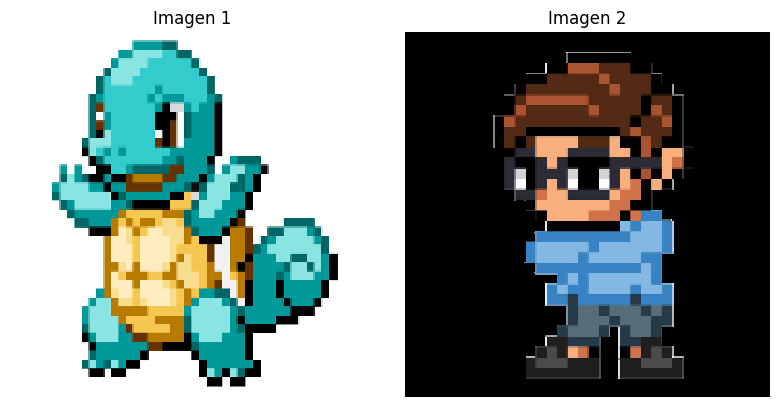

In [ ]:
#Cargar las imágenes desde carpeta
ruta_imagenes = "/content/imagenes_16bit"
paths = sorted(glob(os.path.join(ruta_imagenes, "*.png")))
imgs = np.array([cargar_y_preprocesar(p) for p in paths], dtype=np.float32)

print("Forma de los tensores de entrada:", imgs.shape)

# Mostrar las imágenes cargadas
plt.figure(figsize=(12, 4))
for i in range(min(3, len(imgs))):
    plt.subplot(1, 3, i + 1)
    plot_color_image(imgs[i])
    plt.title(f"Imagen {i+1}")
plt.tight_layout()
plt.show()

In [ ]:
##Definir entrada del modelo con la misma forma que las imágenes cargadas
inputs = keras.Input(shape=imgs.shape[1:])
#Capa convolucional 2D con 2 filtros de tamaño 7x7, paso de pixeles de 1, tamaño de salida igual al de entrada y funcion de activacion relu
x = keras.layers.Conv2D(filters=2, kernel_size=3, strides=1, padding="SAME", activation="relu")(inputs)
#Capa de max pooling que reduce a la mitad el tamaño espacial (altura y ancho)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
#Promedio global de cada mapa de características
x = keras.layers.GlobalAvgPool2D()(x)
x = keras.layers.Flatten()(x)
#Capa de salida con 2 neuronas (correspondientes a 2 clases).
outputs = keras.layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 2)    │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 2)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62 (248.00 B)

 Trainable params: 62 (248.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Como no tenemos etiquetas reales, se generarán aleatoriamente para ejemplo
etiquetas = np.random.randint(0, 2, size=(len(imgs),))

# Compilar y entrenar modelo
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(imgs, etiquetas, epochs=5)

# Visualizar salidas de los feature maps
salidas = keras.Model(inputs=model.input, outputs=model.layers[1].output)  # capa de conv2D
activaciones = salidas.predict(imgs)

Epoch 1/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 1.7354
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5000 - loss: 1.7159
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.5000 - loss: 1.6968
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5000 - loss: 1.6779
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.5000 - loss: 1.6589
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


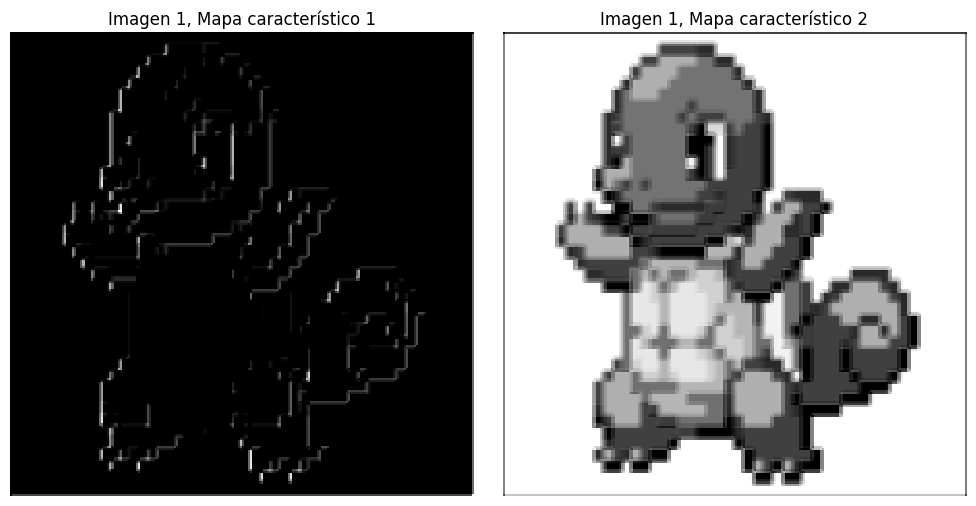

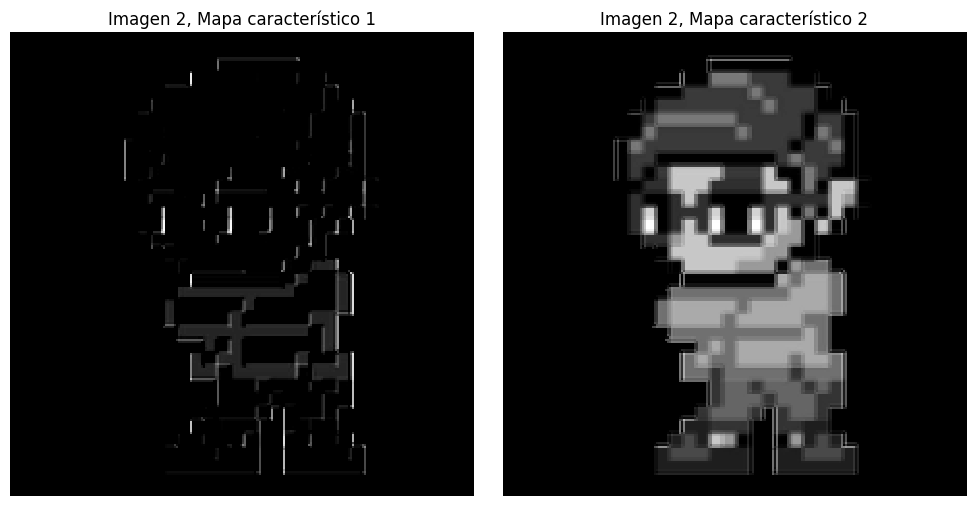

In [ ]:
# Graficar los mapas de características de las imagenes
for img_idx in range(min(3, len(imgs))):
    plt.figure(figsize=(10, 5))
    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plot_image(activaciones[img_idx, :, :, i])
        plt.title(f"Imagen {img_idx+1}, Mapa característico {i+1}")
    plt.tight_layout()
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Full HD

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
import requests
from PIL import Image
from io import BytesIO
import os

In [ ]:
API_KEY = "491jQYEdtArAdQoxRLQCDewCZhXBXT90LqzTRlPRlh8dStKtiHbVxjAk"
QUERY = "landscape"
CANTIDAD = 5
SIZE = (1080, 1920)

def obtener_urls_pexels(query="landscape", cantidad=5, api_key=API_KEY):
    headers = {"Authorization": api_key}
    url = f"https://api.pexels.com/v1/search?query={query}&per_page={cantidad}"
    response = requests.get(url, headers=headers)
    data = response.json()
    urls = [foto["src"]["original"] for foto in data["photos"]]
    nombres = [f"{query}_{i+1}.jpg" for i in range(len(urls))]
    return urls, nombres

def cargar_imagen_desde_url_como_array(url, size=(1080, 1920)):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    img = img.resize((size[1], size[0]))
    return image.img_to_array(img) / 255.0


urls, nombres_imagenes = obtener_urls_pexels(query=QUERY, cantidad=CANTIDAD)
imagenes_array = [cargar_imagen_desde_url_como_array(url, size=SIZE) for url in urls]
imagenes_array = np.array(imagenes_array)

print(f"{len(imagenes_array)} imágenes cargadas con tamaño {imagenes_array.shape[1:]}")


5 imágenes cargadas con tamaño (1080, 1920, 3)


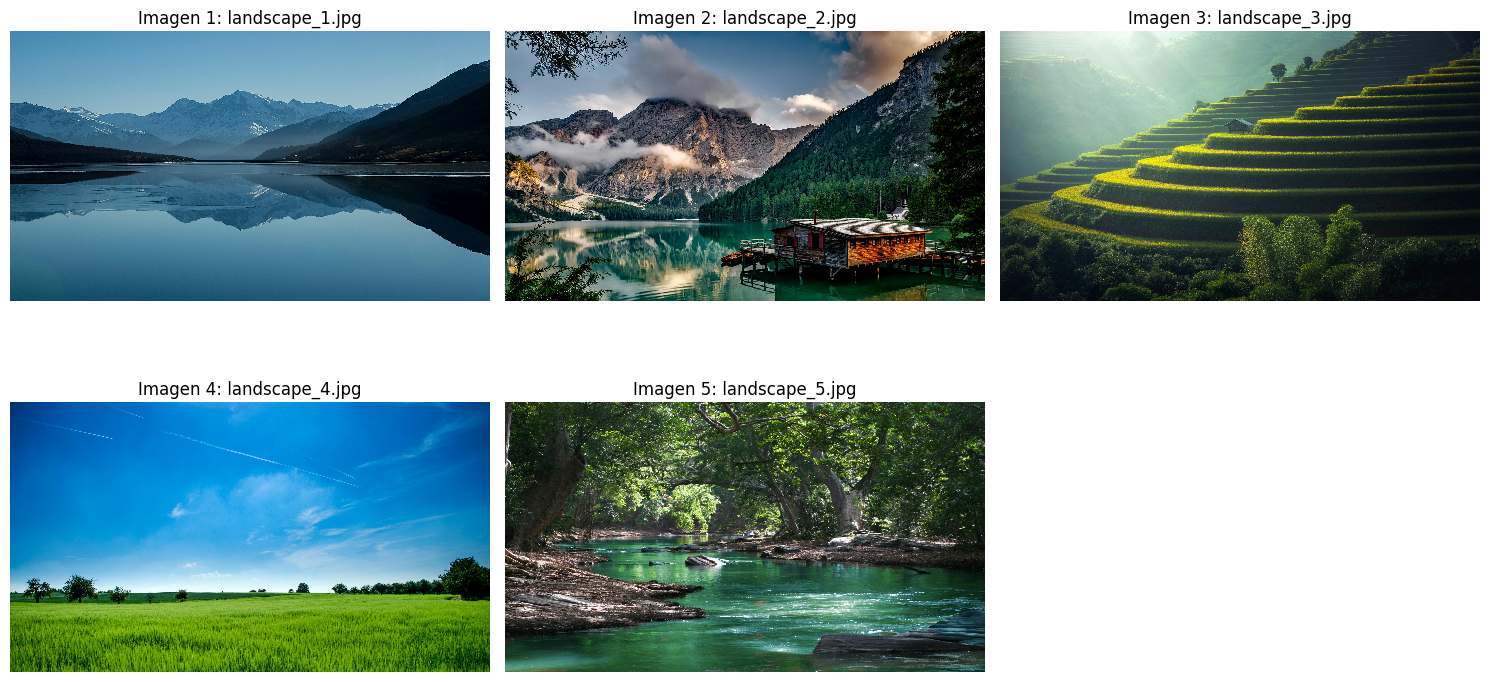

In [ ]:
import matplotlib.pyplot as plt
import math

# Número total de imágenes
num_imgs = len(imagenes_array)

# Tamaño de la figura
plt.figure(figsize=(15, 4 * math.ceil(num_imgs / 3)))

# Mostrar todas las imágenes
for i in range(num_imgs):
    plt.subplot(math.ceil(num_imgs / 3), 3, i + 1)
    plt.imshow(imagenes_array[i].squeeze(), cmap='gray', interpolation='nearest')
    plt.title(f"Imagen {i+1}: {nombres_imagenes[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation="relu", padding="same")

inputs = keras.Input(shape=(1080, 1920, 3))
x = DefaultConv2D(filters=64, kernel_size=7)(inputs)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = DefaultConv2D(filters=128)(x)
x = DefaultConv2D(filters=128)(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)
x = DefaultConv2D(filters=256)(x)
x = DefaultConv2D(filters=256)(x)
x = keras.layers.MaxPooling2D(pool_size=2)(x)

model = keras.Model(inputs=inputs, outputs=x)

In [ ]:
# Obtener solo la última capa convolucional
last_conv_layer = [layer for layer in model.layers if isinstance(layer, keras.layers.Conv2D)][-1]

# Modelo que da como salida solo esa capa
feature_map_model = keras.models.Model(inputs=model.input, outputs=last_conv_layer.output)

# Asegurar que las imágenes estén en formato numpy array
imagenes_array = np.array(imagenes_array)

# Procesar en lote
feature_maps = feature_map_model.predict(imagenes_array)


1/1 ━━━━━━━━━━━━━━━━━━━━ 36s 36s/step


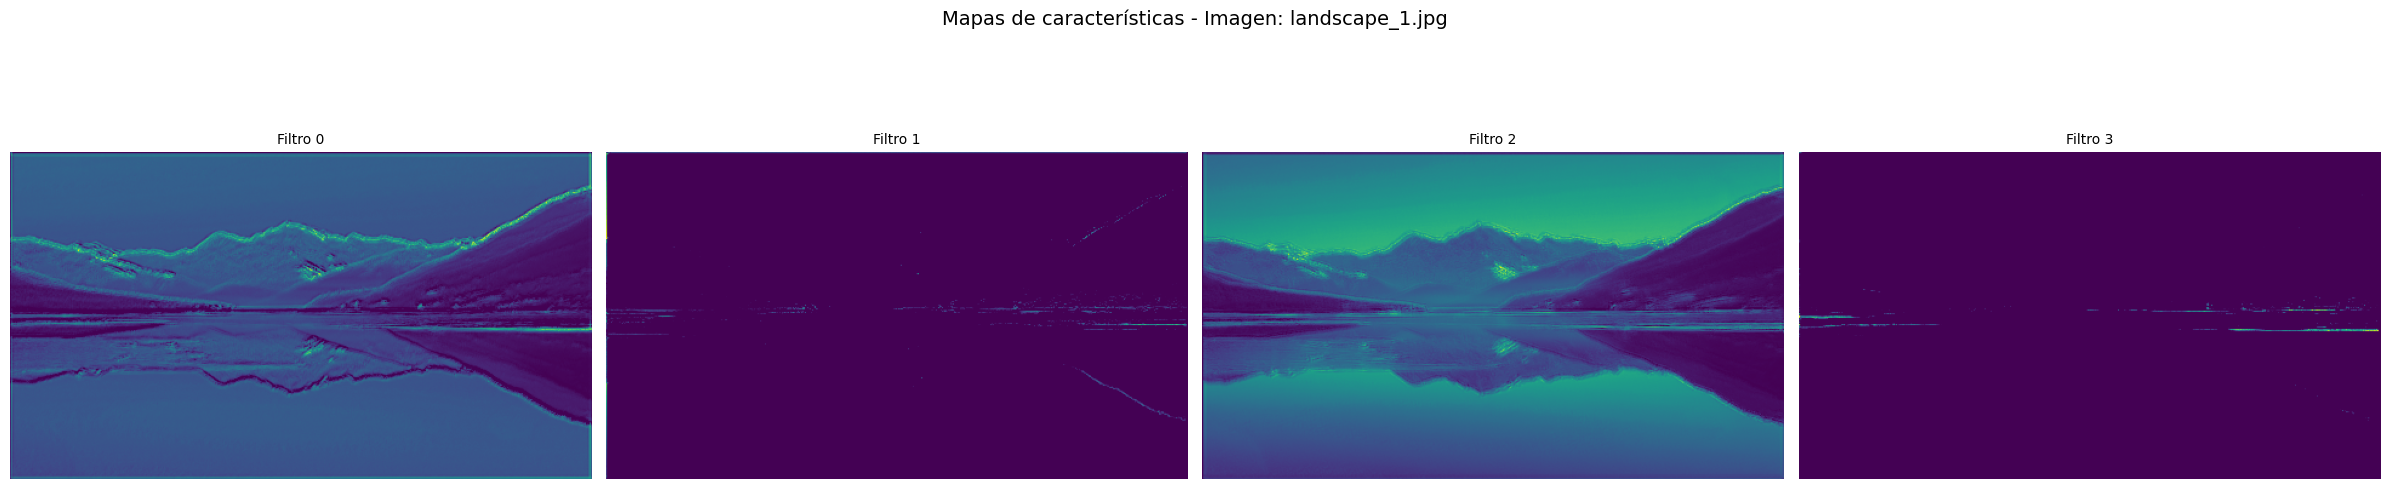

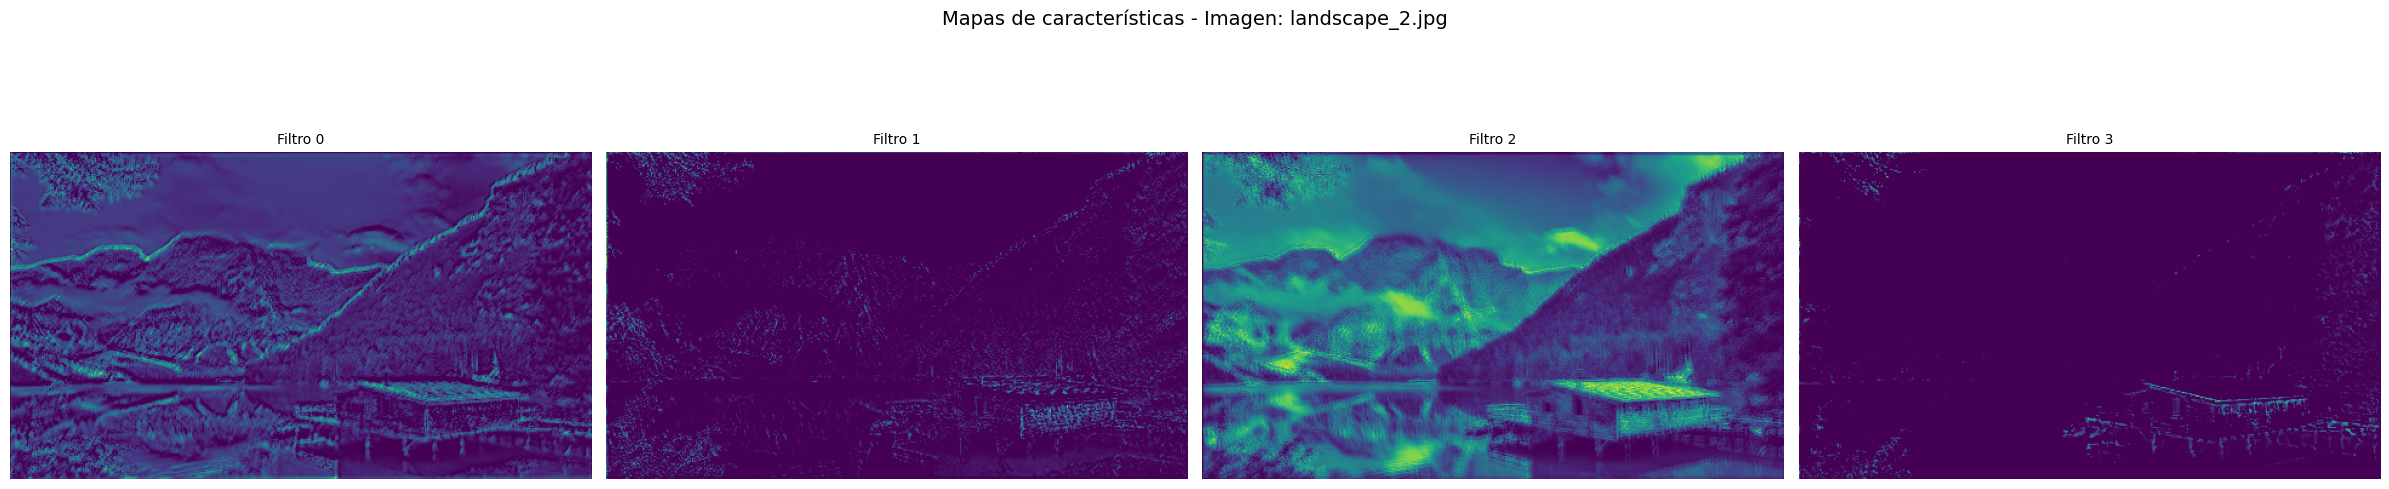

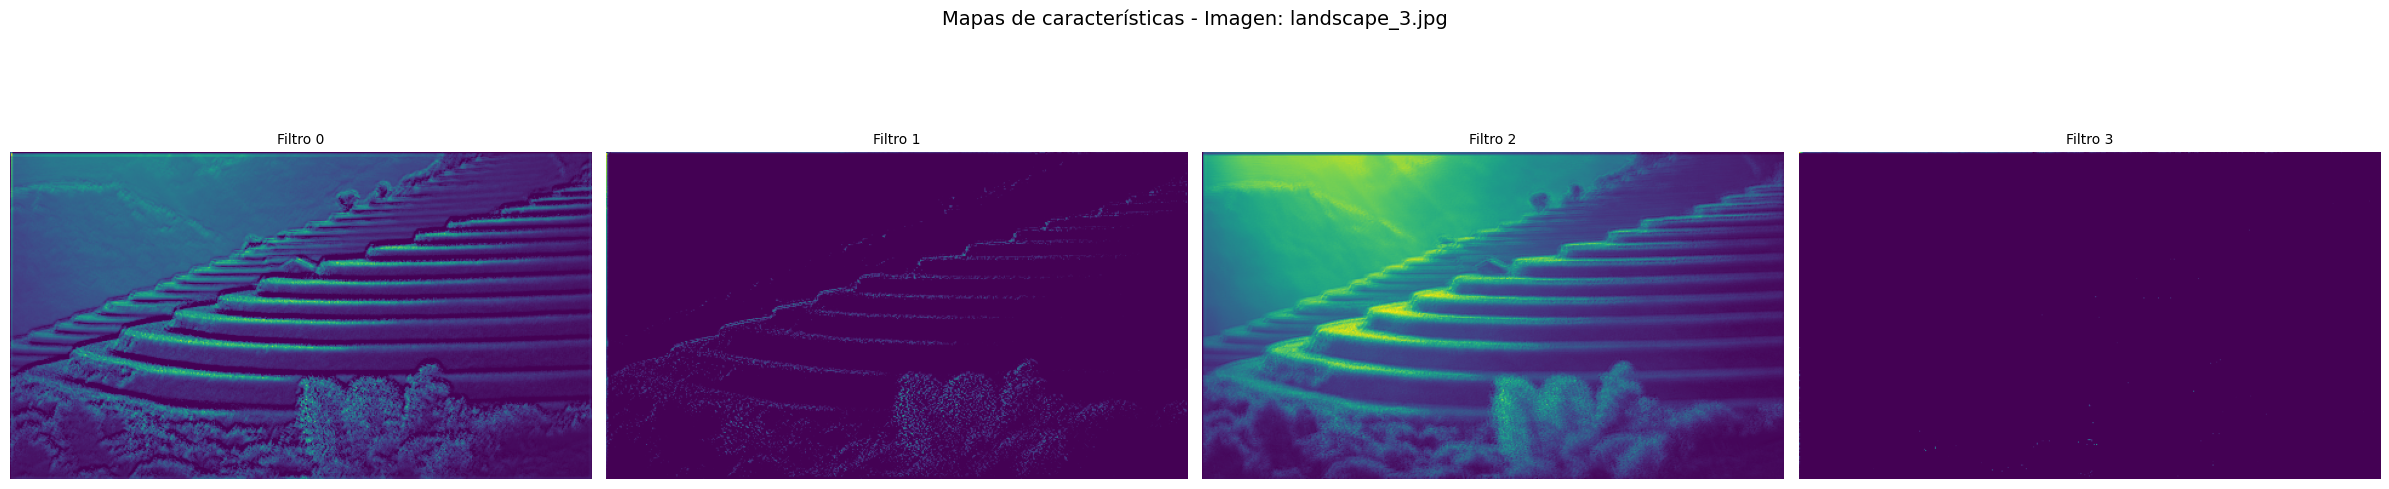

In [ ]:
import matplotlib.pyplot as plt

def mostrar_todos_los_maps(features, nombres_imagenes, filtros=6, zoom=6):
    num_imagenes = len(features)

    for idx in range(num_imagenes):
        maps = features[idx]  # (alto, ancho, canales)
        num_filtros = min(filtros, maps.shape[-1])

        fig, axes = plt.subplots(1, num_filtros, figsize=(zoom * num_filtros, zoom))

        for i in range(num_filtros):
            axes[i].imshow(maps[:, :, i], cmap='viridis')
            axes[i].axis('off')
            axes[i].set_title(f"Filtro {i}", fontsize=10)

        plt.suptitle(f"Mapas de características - Imagen: {nombres_imagenes[idx]}", fontsize=14)
        plt.tight_layout()
        plt.show()

# Llamar a la función
mostrar_todos_los_maps(feature_maps, nombres_imagenes, filtros=4, zoom=6)
